In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import math
import matplotlib.pyplot as plt

import pathlib
from tqdm import tqdm

from visualisation import visualize_samples, visualize_results
from evaluation import psnr, mse, ssim
from models import SRCNN, ESPCN, SRGenerator, SRDiscriminator

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
class SuperResolutionDataset(Dataset):
    def __init__(self, hr_dir, lr_dir):
        self.hr_dir = hr_dir
        self.lr_dir = lr_dir
        # Get file names without extension
        self.file_names = [f.stem for f in self.hr_dir.glob("*.npy")]
        self.hr_files = sorted(self.hr_dir.glob("HR_*.npy"))
        self.lr_files = sorted(self.lr_dir.glob("LR_*.npy"))

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        hr_file_name = self.hr_files[idx]
        lr_file_name = self.lr_files[idx]

        hr_path = f"{hr_file_name}"
        lr_path = f"{lr_file_name}"

        # Load .npy files
        hr_image = np.load(hr_path).astype(np.float32)
        lr_image = np.load(lr_path).astype(np.float32)

        # Convert to PyTorch tensors
        hr_image = torch.from_numpy(hr_image)  # Assuming images are (H, W, C)
        lr_image = torch.from_numpy(lr_image)

        return lr_image, hr_image

In [5]:
hr_dir = pathlib.Path("Dataset 3B") / "HR"
lr_dir = pathlib.Path("Dataset 3B") / "LR"

hr_dir, lr_dir

(PosixPath('Dataset 3B/HR'), PosixPath('Dataset 3B/LR'))

In [29]:
# Create dataset
dataset = SuperResolutionDataset(hr_dir, lr_dir)

# Train-test split (90-10)
train_size = 0.9  # 90%
test_size = 0.1    # 10%
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Add custom transforms for Data Augmentation
train_dataset.transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), interpolation=transforms.InterpolationMode.BICUBIC)
])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Example usage
for lr, hr in train_loader:
    print(f"LR shape: {lr.shape}, HR shape: {hr.shape}")
    break

LR shape: torch.Size([16, 1, 64, 64]), HR shape: torch.Size([16, 1, 128, 128])


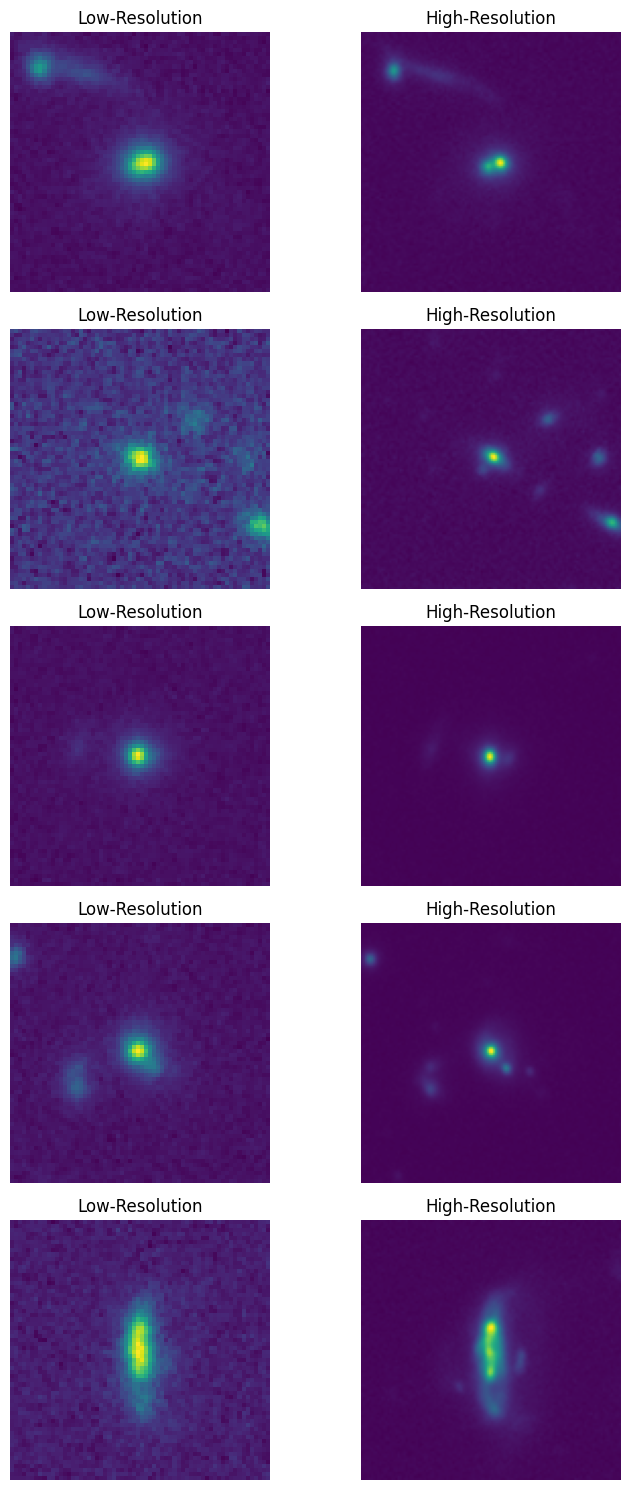

In [19]:
visualize_samples(train_loader, num_samples=5)

# Fine-tuning

## SRCNN Models

### SRCNN Model 1

In [31]:
model = SRCNN(2, 64, [32], 5, [1], 3)
model = model.to(device)
model_load_path = "saved_models/best_sr_model.pth" 
model.load_state_dict(torch.load(model_load_path))

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 200
patience = 10  # Stop training if no improvement for 5 consecutive epochs
best_val_loss = float('inf')
epochs_no_improve = 0
model_save_path = "saved_models/best_sr_model_ft_1.pth"  # Path to save the best model

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for lr_imgs, hr_imgs in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)

        sr_imgs = model(lr_imgs)

        loss = criterion(sr_imgs, hr_imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # Validation step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for lr_imgs, hr_imgs in test_loader:
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
            sr_imgs = model(lr_imgs)
            val_loss += criterion(sr_imgs, hr_imgs).item()

    avg_val_loss = val_loss / len(test_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")

    # Early Stopping & Model Saving
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), model_save_path)  # Save best model
        print(f"✔ Model saved with Val Loss: {best_val_loss}")
    else:
        epochs_no_improve += 1
        print(f"❌ No improvement for {epochs_no_improve}/{patience} epochs.")

    if epochs_no_improve >= patience:
        print("⏹ Early stopping triggered!")
        break  # Stop training if no improvement for 'patience' epochs

print("✅ Training complete!")
print(f"📁 Best model saved at: {model_save_path}")

Epoch 1/200:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 1/200: 100%|██████████| 17/17 [00:00<00:00, 37.63it/s]


Epoch [1/200] - Train Loss: 0.005625904089195982, Val Loss: 0.0017955831135623157
✔ Model saved with Val Loss: 0.0017955831135623157


Epoch 2/200: 100%|██████████| 17/17 [00:00<00:00, 39.20it/s]


Epoch [2/200] - Train Loss: 0.0023037423140040655, Val Loss: 0.0013338814896997064
✔ Model saved with Val Loss: 0.0013338814896997064


Epoch 3/200: 100%|██████████| 17/17 [00:00<00:00, 39.23it/s]


Epoch [3/200] - Train Loss: 0.001932354804867988, Val Loss: 0.0012333345075603575
✔ Model saved with Val Loss: 0.0012333345075603575


Epoch 4/200: 100%|██████████| 17/17 [00:00<00:00, 41.18it/s]


Epoch [4/200] - Train Loss: 0.0017687254996203324, Val Loss: 0.001120699045713991
✔ Model saved with Val Loss: 0.001120699045713991


Epoch 5/200: 100%|██████████| 17/17 [00:00<00:00, 39.26it/s]


Epoch [5/200] - Train Loss: 0.0017447686884278322, Val Loss: 0.0010985402623191476
✔ Model saved with Val Loss: 0.0010985402623191476


Epoch 6/200: 100%|██████████| 17/17 [00:00<00:00, 40.32it/s]


Epoch [6/200] - Train Loss: 0.0016529482399003908, Val Loss: 0.0010904499213211238
✔ Model saved with Val Loss: 0.0010904499213211238


Epoch 7/200: 100%|██████████| 17/17 [00:00<00:00, 38.63it/s]


Epoch [7/200] - Train Loss: 0.0016340192386825733, Val Loss: 0.0011061576078645885
❌ No improvement for 1/10 epochs.


Epoch 8/200: 100%|██████████| 17/17 [00:00<00:00, 38.47it/s]


Epoch [8/200] - Train Loss: 0.0016185675973675268, Val Loss: 0.0010914808372035623
❌ No improvement for 2/10 epochs.


Epoch 9/200: 100%|██████████| 17/17 [00:00<00:00, 41.58it/s]


Epoch [9/200] - Train Loss: 0.0016014719559975406, Val Loss: 0.0011018993973266333
❌ No improvement for 3/10 epochs.


Epoch 10/200: 100%|██████████| 17/17 [00:00<00:00, 41.49it/s]


Epoch [10/200] - Train Loss: 0.0015865775879801197, Val Loss: 0.0010899809130933136
✔ Model saved with Val Loss: 0.0010899809130933136


Epoch 11/200: 100%|██████████| 17/17 [00:00<00:00, 41.43it/s]


Epoch [11/200] - Train Loss: 0.001580718661631074, Val Loss: 0.0010774595430120826
✔ Model saved with Val Loss: 0.0010774595430120826


Epoch 12/200: 100%|██████████| 17/17 [00:00<00:00, 41.57it/s]


Epoch [12/200] - Train Loss: 0.001600581217858502, Val Loss: 0.0010654156212694943
✔ Model saved with Val Loss: 0.0010654156212694943


Epoch 13/200: 100%|██████████| 17/17 [00:00<00:00, 41.62it/s]


Epoch [13/200] - Train Loss: 0.0015676479841418127, Val Loss: 0.0010830076062120497
❌ No improvement for 1/10 epochs.


Epoch 14/200: 100%|██████████| 17/17 [00:00<00:00, 37.57it/s]


Epoch [14/200] - Train Loss: 0.0015386819586103015, Val Loss: 0.0010472014546394348
✔ Model saved with Val Loss: 0.0010472014546394348


Epoch 15/200: 100%|██████████| 17/17 [00:00<00:00, 41.04it/s]


Epoch [15/200] - Train Loss: 0.001512217362794806, Val Loss: 0.0010092826996697113
✔ Model saved with Val Loss: 0.0010092826996697113


Epoch 16/200: 100%|██████████| 17/17 [00:00<00:00, 38.11it/s]


Epoch [16/200] - Train Loss: 0.001500411144019488, Val Loss: 0.0010148430737899616
❌ No improvement for 1/10 epochs.


Epoch 17/200: 100%|██████████| 17/17 [00:00<00:00, 40.96it/s]


Epoch [17/200] - Train Loss: 0.0014837835299070267, Val Loss: 0.0009773545898497105
✔ Model saved with Val Loss: 0.0009773545898497105


Epoch 18/200: 100%|██████████| 17/17 [00:00<00:00, 40.62it/s]


Epoch [18/200] - Train Loss: 0.0014672663220313981, Val Loss: 0.0009772742487257347
✔ Model saved with Val Loss: 0.0009772742487257347


Epoch 19/200: 100%|██████████| 17/17 [00:00<00:00, 40.59it/s]


Epoch [19/200] - Train Loss: 0.0014648572353454417, Val Loss: 0.0009818389953579754
❌ No improvement for 1/10 epochs.


Epoch 20/200: 100%|██████████| 17/17 [00:00<00:00, 41.22it/s]


Epoch [20/200] - Train Loss: 0.0014825209509581327, Val Loss: 0.0009549474343657494
✔ Model saved with Val Loss: 0.0009549474343657494


Epoch 21/200: 100%|██████████| 17/17 [00:00<00:00, 41.17it/s]


Epoch [21/200] - Train Loss: 0.0014611646115286823, Val Loss: 0.0009791195334400982
❌ No improvement for 1/10 epochs.


Epoch 22/200: 100%|██████████| 17/17 [00:00<00:00, 41.16it/s]


Epoch [22/200] - Train Loss: 0.0014539709355791703, Val Loss: 0.0009580530459061265
❌ No improvement for 2/10 epochs.


Epoch 23/200: 100%|██████████| 17/17 [00:00<00:00, 38.97it/s]


Epoch [23/200] - Train Loss: 0.0014396000359043041, Val Loss: 0.0009550236572977155
❌ No improvement for 3/10 epochs.


Epoch 24/200: 100%|██████████| 17/17 [00:00<00:00, 40.93it/s]


Epoch [24/200] - Train Loss: 0.0014390621389098028, Val Loss: 0.0009451177029404789
✔ Model saved with Val Loss: 0.0009451177029404789


Epoch 25/200: 100%|██████████| 17/17 [00:00<00:00, 38.19it/s]


Epoch [25/200] - Train Loss: 0.001435750099035966, Val Loss: 0.0009487562201684341
❌ No improvement for 1/10 epochs.


Epoch 26/200: 100%|██████████| 17/17 [00:00<00:00, 40.64it/s]


Epoch [26/200] - Train Loss: 0.0015039548058720196, Val Loss: 0.0009195735037792474
✔ Model saved with Val Loss: 0.0009195735037792474


Epoch 27/200: 100%|██████████| 17/17 [00:00<00:00, 40.80it/s]


Epoch [27/200] - Train Loss: 0.0014323330679497518, Val Loss: 0.0009508773218840361
❌ No improvement for 1/10 epochs.


Epoch 28/200: 100%|██████████| 17/17 [00:00<00:00, 38.50it/s]


Epoch [28/200] - Train Loss: 0.0014224321143153835, Val Loss: 0.0009475061378907412
❌ No improvement for 2/10 epochs.


Epoch 29/200: 100%|██████████| 17/17 [00:00<00:00, 41.13it/s]


Epoch [29/200] - Train Loss: 0.0014496097163132886, Val Loss: 0.0009275389602407813
❌ No improvement for 3/10 epochs.


Epoch 30/200: 100%|██████████| 17/17 [00:00<00:00, 40.46it/s]


Epoch [30/200] - Train Loss: 0.0014265974665142816, Val Loss: 0.0009303626284236088
❌ No improvement for 4/10 epochs.


Epoch 31/200: 100%|██████████| 17/17 [00:00<00:00, 41.00it/s]


Epoch [31/200] - Train Loss: 0.001425982137922855, Val Loss: 0.0009416794346179813
❌ No improvement for 5/10 epochs.


Epoch 32/200: 100%|██████████| 17/17 [00:00<00:00, 38.74it/s]


Epoch [32/200] - Train Loss: 0.0014124126584433457, Val Loss: 0.000941259422688745
❌ No improvement for 6/10 epochs.


Epoch 33/200: 100%|██████████| 17/17 [00:00<00:00, 39.95it/s]


Epoch [33/200] - Train Loss: 0.0014087008295224652, Val Loss: 0.0009244901011697948
❌ No improvement for 7/10 epochs.


Epoch 34/200: 100%|██████████| 17/17 [00:00<00:00, 41.22it/s]


Epoch [34/200] - Train Loss: 0.001408425416550873, Val Loss: 0.000912571995286271
✔ Model saved with Val Loss: 0.000912571995286271


Epoch 35/200: 100%|██████████| 17/17 [00:00<00:00, 41.36it/s]


Epoch [35/200] - Train Loss: 0.001409343714305364, Val Loss: 0.0009188323601847515
❌ No improvement for 1/10 epochs.


Epoch 36/200: 100%|██████████| 17/17 [00:00<00:00, 41.04it/s]


Epoch [36/200] - Train Loss: 0.0014050066426588112, Val Loss: 0.0009356108639622107
❌ No improvement for 2/10 epochs.


Epoch 37/200: 100%|██████████| 17/17 [00:00<00:00, 41.30it/s]


Epoch [37/200] - Train Loss: 0.0014033257543547627, Val Loss: 0.0009271422313759103
❌ No improvement for 3/10 epochs.


Epoch 38/200: 100%|██████████| 17/17 [00:00<00:00, 41.22it/s]


Epoch [38/200] - Train Loss: 0.0014089637278469607, Val Loss: 0.000915793192689307
❌ No improvement for 4/10 epochs.


Epoch 39/200: 100%|██████████| 17/17 [00:00<00:00, 40.51it/s]


Epoch [39/200] - Train Loss: 0.0014595644195865402, Val Loss: 0.0009120526519836858
✔ Model saved with Val Loss: 0.0009120526519836858


Epoch 40/200: 100%|██████████| 17/17 [00:00<00:00, 38.41it/s]


Epoch [40/200] - Train Loss: 0.0013992377584252287, Val Loss: 0.00091752884327434
❌ No improvement for 1/10 epochs.


Epoch 41/200: 100%|██████████| 17/17 [00:00<00:00, 39.16it/s]


Epoch [41/200] - Train Loss: 0.0014044008395798942, Val Loss: 0.0009209915879182518
❌ No improvement for 2/10 epochs.


Epoch 42/200: 100%|██████████| 17/17 [00:00<00:00, 40.99it/s]


Epoch [42/200] - Train Loss: 0.001399754430167377, Val Loss: 0.000910223345272243
✔ Model saved with Val Loss: 0.000910223345272243


Epoch 43/200: 100%|██████████| 17/17 [00:00<00:00, 39.56it/s]


Epoch [43/200] - Train Loss: 0.001399515912292854, Val Loss: 0.0009144174255197868
❌ No improvement for 1/10 epochs.


Epoch 44/200: 100%|██████████| 17/17 [00:00<00:00, 38.98it/s]


Epoch [44/200] - Train Loss: 0.0014117046255919645, Val Loss: 0.0009282130631618202
❌ No improvement for 2/10 epochs.


Epoch 45/200: 100%|██████████| 17/17 [00:00<00:00, 41.03it/s]


Epoch [45/200] - Train Loss: 0.001395783233045436, Val Loss: 0.0009251503506675363
❌ No improvement for 3/10 epochs.


Epoch 46/200: 100%|██████████| 17/17 [00:00<00:00, 41.20it/s]


Epoch [46/200] - Train Loss: 0.001400017987608033, Val Loss: 0.0009099347371375188
✔ Model saved with Val Loss: 0.0009099347371375188


Epoch 47/200: 100%|██████████| 17/17 [00:00<00:00, 41.20it/s]


Epoch [47/200] - Train Loss: 0.0013896814061273985, Val Loss: 0.0009149194229394197
❌ No improvement for 1/10 epochs.


Epoch 48/200: 100%|██████████| 17/17 [00:00<00:00, 41.59it/s]


Epoch [48/200] - Train Loss: 0.0013880200619014965, Val Loss: 0.0009089561353903264
✔ Model saved with Val Loss: 0.0009089561353903264


Epoch 49/200: 100%|██████████| 17/17 [00:00<00:00, 40.70it/s]


Epoch [49/200] - Train Loss: 0.001387626280227457, Val Loss: 0.0009075854031834751
✔ Model saved with Val Loss: 0.0009075854031834751


Epoch 50/200: 100%|██████████| 17/17 [00:00<00:00, 41.08it/s]


Epoch [50/200] - Train Loss: 0.001395715744686587, Val Loss: 0.0009002916340250522
✔ Model saved with Val Loss: 0.0009002916340250522


Epoch 51/200: 100%|██████████| 17/17 [00:00<00:00, 40.40it/s]


Epoch [51/200] - Train Loss: 0.0013878849807524068, Val Loss: 0.0008969904738478363
✔ Model saved with Val Loss: 0.0008969904738478363


Epoch 52/200: 100%|██████████| 17/17 [00:00<00:00, 38.91it/s]


Epoch [52/200] - Train Loss: 0.001398637705920812, Val Loss: 0.0009245978872058913
❌ No improvement for 1/10 epochs.


Epoch 53/200: 100%|██████████| 17/17 [00:00<00:00, 40.67it/s]


Epoch [53/200] - Train Loss: 0.0013980654287425911, Val Loss: 0.0009159692126559094
❌ No improvement for 2/10 epochs.


Epoch 54/200: 100%|██████████| 17/17 [00:00<00:00, 40.47it/s]


Epoch [54/200] - Train Loss: 0.0013895075946279308, Val Loss: 0.0008910601027309895
✔ Model saved with Val Loss: 0.0008910601027309895


Epoch 55/200: 100%|██████████| 17/17 [00:00<00:00, 39.97it/s]


Epoch [55/200] - Train Loss: 0.0013905502273701131, Val Loss: 0.0009135061845881864
❌ No improvement for 1/10 epochs.


Epoch 56/200: 100%|██████████| 17/17 [00:00<00:00, 39.26it/s]


Epoch [56/200] - Train Loss: 0.0013991128122570978, Val Loss: 0.0009080922172870487
❌ No improvement for 2/10 epochs.


Epoch 57/200: 100%|██████████| 17/17 [00:00<00:00, 40.56it/s]


Epoch [57/200] - Train Loss: 0.0013956370154012215, Val Loss: 0.0008828756981529295
✔ Model saved with Val Loss: 0.0008828756981529295


Epoch 58/200: 100%|██████████| 17/17 [00:00<00:00, 41.16it/s]


Epoch [58/200] - Train Loss: 0.0013926737746634684, Val Loss: 0.0008966698660515249
❌ No improvement for 1/10 epochs.


Epoch 59/200: 100%|██████████| 17/17 [00:00<00:00, 40.32it/s]


Epoch [59/200] - Train Loss: 0.0013842492720440908, Val Loss: 0.0009106532525038347
❌ No improvement for 2/10 epochs.


Epoch 60/200: 100%|██████████| 17/17 [00:00<00:00, 41.35it/s]


Epoch [60/200] - Train Loss: 0.0013949587352245169, Val Loss: 0.0009152167767751962
❌ No improvement for 3/10 epochs.


Epoch 61/200: 100%|██████████| 17/17 [00:00<00:00, 41.39it/s]


Epoch [61/200] - Train Loss: 0.0014101972509011189, Val Loss: 0.0009092710824916139
❌ No improvement for 4/10 epochs.


Epoch 62/200: 100%|██████████| 17/17 [00:00<00:00, 41.01it/s]


Epoch [62/200] - Train Loss: 0.0013803334441035986, Val Loss: 0.0009077646682271734
❌ No improvement for 5/10 epochs.


Epoch 63/200: 100%|██████████| 17/17 [00:00<00:00, 41.36it/s]


Epoch [63/200] - Train Loss: 0.0013913857829346158, Val Loss: 0.000912726522074081
❌ No improvement for 6/10 epochs.


Epoch 64/200: 100%|██████████| 17/17 [00:00<00:00, 40.32it/s]


Epoch [64/200] - Train Loss: 0.0013950037485782934, Val Loss: 0.0009064455662155524
❌ No improvement for 7/10 epochs.


Epoch 65/200: 100%|██████████| 17/17 [00:00<00:00, 38.88it/s]


Epoch [65/200] - Train Loss: 0.0013837650339530013, Val Loss: 0.0008964516455307603
❌ No improvement for 8/10 epochs.


Epoch 66/200: 100%|██████████| 17/17 [00:00<00:00, 39.36it/s]


Epoch [66/200] - Train Loss: 0.0013868799022234539, Val Loss: 0.0009072754910448566
❌ No improvement for 9/10 epochs.


Epoch 67/200: 100%|██████████| 17/17 [00:00<00:00, 38.10it/s]


Epoch [67/200] - Train Loss: 0.0013794520020704059, Val Loss: 0.0009048680949490517
❌ No improvement for 10/10 epochs.
⏹ Early stopping triggered!
✅ Training complete!
📁 Best model saved at: saved_models/best_sr_model_ft_1.pth


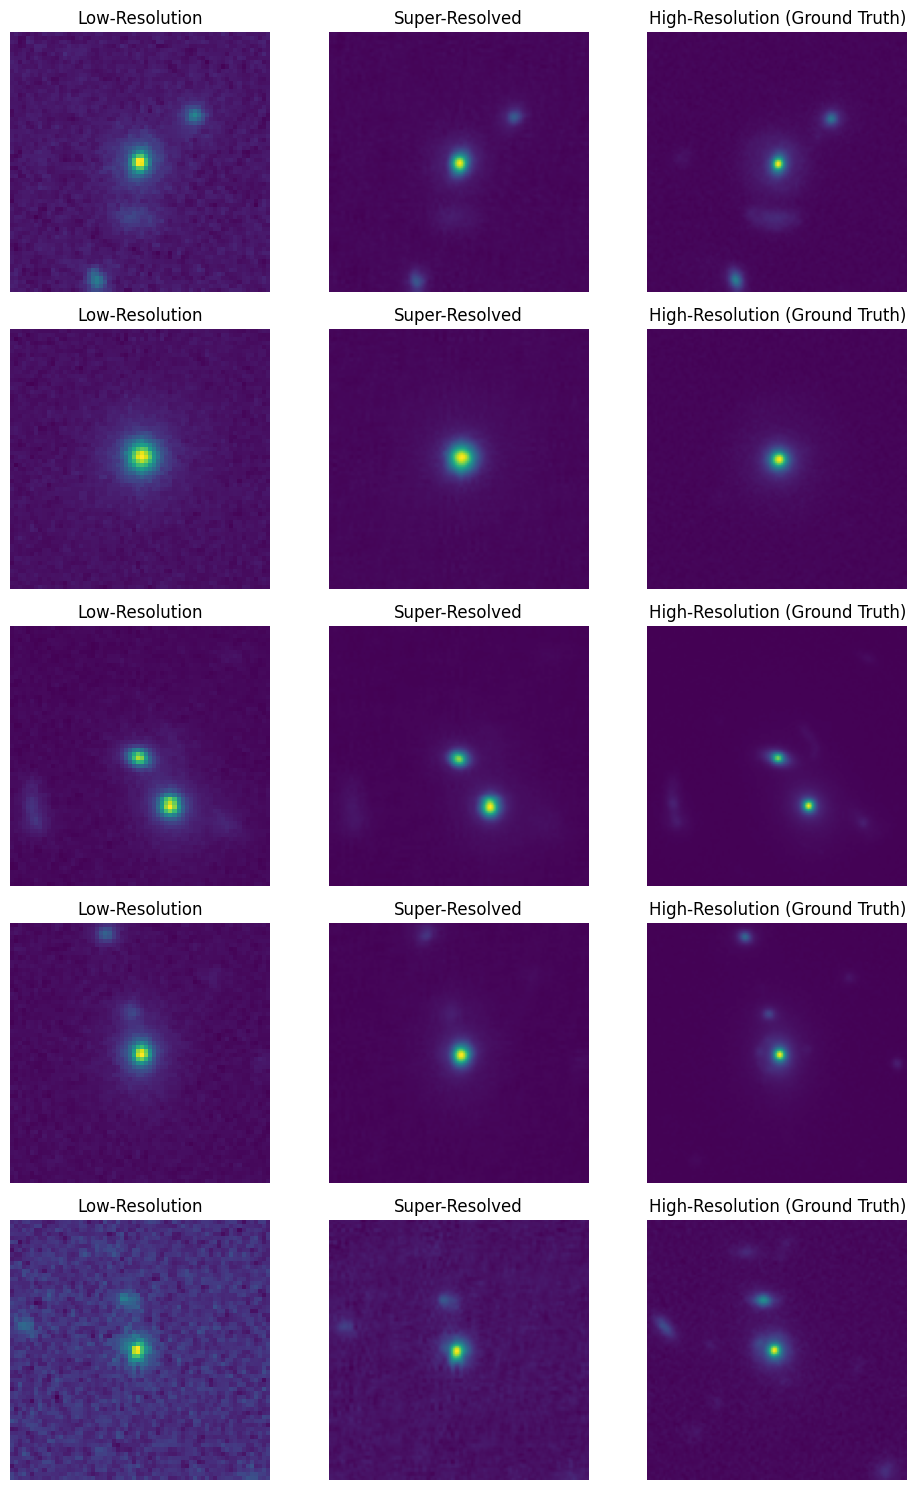

Final Evaluation - MSE: 0.0008473546695313416, PSNR: 34.09434717290395, SSIM: 0.85820458928744


In [33]:
model = SRCNN(2, 64, [32], 5, [1], 3)
model = model.to(device)
model_save_path = "saved_models/best_sr_model_ft_1.pth"
model.load_state_dict(torch.load(model_save_path))
visualize_results(model, test_loader, num_samples=5, device=device)

model.eval()

# Evaluation loop
total_psnr, total_ssim, total_mse = 0.0, 0.0, 0.0
num_images = 0

with torch.no_grad():
    for lr_imgs, hr_imgs in test_loader:
        lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
        sr_imgs = model(lr_imgs)  # Generate SR images

        # Compute MSE, PSNR & SSIM for each image
        for i in range(lr_imgs.shape[0]):
            total_mse += mse(sr_imgs[i], hr_imgs[i])
            total_psnr += psnr(sr_imgs[i], hr_imgs[i], 255)
            total_ssim += ssim(sr_imgs[i].unsqueeze(0), hr_imgs[i].unsqueeze(0))
            num_images += 1

# Compute final average MSE, PSNR & SSIM
avg_mse = total_mse / num_images
avg_psnr = total_psnr / num_images
avg_ssim = total_ssim / num_images

print(f"Final Evaluation - MSE: {avg_mse}, PSNR: {avg_psnr}, SSIM: {avg_ssim}")

### SRCNN Model 2

In [34]:
model = SRCNN(2, 32, [16], 9, [3], 5)
model = model.to(device)
model_load_path = "saved_models/best_sr_model_2.pth" 
model.load_state_dict(torch.load(model_load_path))

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 200
patience = 10  # Stop training if no improvement for 5 consecutive epochs
best_val_loss = float('inf')
epochs_no_improve = 0
model_save_path = "saved_models/best_sr_model_ft_2.pth"  # Path to save the best model

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for lr_imgs, hr_imgs in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)

        sr_imgs = model(lr_imgs)

        loss = criterion(sr_imgs, hr_imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # Validation step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for lr_imgs, hr_imgs in test_loader:
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
            sr_imgs = model(lr_imgs)
            val_loss += criterion(sr_imgs, hr_imgs).item()

    avg_val_loss = val_loss / len(test_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")

    # Early Stopping & Model Saving
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), model_save_path)  # Save best model
        print(f"✔ Model saved with Val Loss: {best_val_loss}")
    else:
        epochs_no_improve += 1
        print(f"❌ No improvement for {epochs_no_improve}/{patience} epochs.")

    if epochs_no_improve >= patience:
        print("⏹ Early stopping triggered!")
        break  # Stop training if no improvement for 'patience' epochs

print("✅ Training complete!")
print(f"📁 Best model saved at: {model_save_path}")

Epoch 1/200:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 1/200: 100%|██████████| 17/17 [00:00<00:00, 41.86it/s]


Epoch [1/200] - Train Loss: 0.004270251566434608, Val Loss: 0.0011772134166676551
✔ Model saved with Val Loss: 0.0011772134166676551


Epoch 2/200: 100%|██████████| 17/17 [00:00<00:00, 44.98it/s]


Epoch [2/200] - Train Loss: 0.0018956477699034354, Val Loss: 0.0013419113238342106
❌ No improvement for 1/10 epochs.


Epoch 3/200: 100%|██████████| 17/17 [00:00<00:00, 42.04it/s]


Epoch [3/200] - Train Loss: 0.0017255446428487845, Val Loss: 0.0011136718676425517
✔ Model saved with Val Loss: 0.0011136718676425517


Epoch 4/200: 100%|██████████| 17/17 [00:00<00:00, 42.44it/s]


Epoch [4/200] - Train Loss: 0.0016635443864609389, Val Loss: 0.0010914892482105643
✔ Model saved with Val Loss: 0.0010914892482105643


Epoch 5/200: 100%|██████████| 17/17 [00:00<00:00, 45.11it/s]


Epoch [5/200] - Train Loss: 0.0016117661965408309, Val Loss: 0.0010852430132217705
✔ Model saved with Val Loss: 0.0010852430132217705


Epoch 6/200: 100%|██████████| 17/17 [00:00<00:00, 44.54it/s]


Epoch [6/200] - Train Loss: 0.0015664860017268972, Val Loss: 0.0010569736768957227
✔ Model saved with Val Loss: 0.0010569736768957227


Epoch 7/200: 100%|██████████| 17/17 [00:00<00:00, 46.54it/s]


Epoch [7/200] - Train Loss: 0.0015407804577775737, Val Loss: 0.0010317175328964368
✔ Model saved with Val Loss: 0.0010317175328964368


Epoch 8/200: 100%|██████████| 17/17 [00:00<00:00, 46.99it/s]


Epoch [8/200] - Train Loss: 0.0015173151486498468, Val Loss: 0.0010319155553588644
❌ No improvement for 1/10 epochs.


Epoch 9/200: 100%|██████████| 17/17 [00:00<00:00, 47.63it/s]


Epoch [9/200] - Train Loss: 0.0015048841938979046, Val Loss: 0.0009966920915758237
✔ Model saved with Val Loss: 0.0009966920915758237


Epoch 10/200: 100%|██████████| 17/17 [00:00<00:00, 47.48it/s]


Epoch [10/200] - Train Loss: 0.0014816654216059867, Val Loss: 0.000987822306342423
✔ Model saved with Val Loss: 0.000987822306342423


Epoch 11/200: 100%|██████████| 17/17 [00:00<00:00, 47.45it/s]


Epoch [11/200] - Train Loss: 0.0014627304318470553, Val Loss: 0.0009783626737771556
✔ Model saved with Val Loss: 0.0009783626737771556


Epoch 12/200: 100%|██████████| 17/17 [00:00<00:00, 47.54it/s]


Epoch [12/200] - Train Loss: 0.0014635070418829426, Val Loss: 0.000964019462116994
✔ Model saved with Val Loss: 0.000964019462116994


Epoch 13/200: 100%|██████████| 17/17 [00:00<00:00, 47.43it/s]


Epoch [13/200] - Train Loss: 0.0014465355471817449, Val Loss: 0.0009493689722148702
✔ Model saved with Val Loss: 0.0009493689722148702


Epoch 14/200: 100%|██████████| 17/17 [00:00<00:00, 45.38it/s]


Epoch [14/200] - Train Loss: 0.0014343104112948127, Val Loss: 0.0009655910107539967
❌ No improvement for 1/10 epochs.


Epoch 15/200: 100%|██████████| 17/17 [00:00<00:00, 40.57it/s]


Epoch [15/200] - Train Loss: 0.0014092829660512507, Val Loss: 0.0009302257094532251
✔ Model saved with Val Loss: 0.0009302257094532251


Epoch 16/200: 100%|██████████| 17/17 [00:00<00:00, 46.04it/s]


Epoch [16/200] - Train Loss: 0.001419446023646742, Val Loss: 0.0009436841355636716
❌ No improvement for 1/10 epochs.


Epoch 17/200: 100%|██████████| 17/17 [00:00<00:00, 45.01it/s]


Epoch [17/200] - Train Loss: 0.0013979162904433906, Val Loss: 0.0009266616689274088
✔ Model saved with Val Loss: 0.0009266616689274088


Epoch 18/200: 100%|██████████| 17/17 [00:00<00:00, 46.66it/s]


Epoch [18/200] - Train Loss: 0.001401198425275438, Val Loss: 0.0009249137947335839
✔ Model saved with Val Loss: 0.0009249137947335839


Epoch 19/200: 100%|██████████| 17/17 [00:00<00:00, 43.32it/s]


Epoch [19/200] - Train Loss: 0.0014015975723262219, Val Loss: 0.0009273820178350434
❌ No improvement for 1/10 epochs.


Epoch 20/200: 100%|██████████| 17/17 [00:00<00:00, 44.85it/s]


Epoch [20/200] - Train Loss: 0.001392908497056102, Val Loss: 0.0009176236781058833
✔ Model saved with Val Loss: 0.0009176236781058833


Epoch 21/200: 100%|██████████| 17/17 [00:00<00:00, 43.56it/s]


Epoch [21/200] - Train Loss: 0.001372314296210842, Val Loss: 0.000921411148738116
❌ No improvement for 1/10 epochs.


Epoch 22/200: 100%|██████████| 17/17 [00:00<00:00, 42.33it/s]


Epoch [22/200] - Train Loss: 0.0013850348392117988, Val Loss: 0.000930364360101521
❌ No improvement for 2/10 epochs.


Epoch 23/200: 100%|██████████| 17/17 [00:00<00:00, 47.06it/s]


Epoch [23/200] - Train Loss: 0.001378692193504642, Val Loss: 0.0008944838191382587
✔ Model saved with Val Loss: 0.0008944838191382587


Epoch 24/200: 100%|██████████| 17/17 [00:00<00:00, 46.09it/s]


Epoch [24/200] - Train Loss: 0.0013787204207962051, Val Loss: 0.0009048915962921456
❌ No improvement for 1/10 epochs.


Epoch 25/200: 100%|██████████| 17/17 [00:00<00:00, 46.82it/s]


Epoch [25/200] - Train Loss: 0.0013697226754362311, Val Loss: 0.0008896151266526431
✔ Model saved with Val Loss: 0.0008896151266526431


Epoch 26/200: 100%|██████████| 17/17 [00:00<00:00, 47.61it/s]


Epoch [26/200] - Train Loss: 0.0013701053291750962, Val Loss: 0.0008985075255623087
❌ No improvement for 1/10 epochs.


Epoch 27/200: 100%|██████████| 17/17 [00:00<00:00, 44.79it/s]


Epoch [27/200] - Train Loss: 0.0013750994488980401, Val Loss: 0.0009493477700743824
❌ No improvement for 2/10 epochs.


Epoch 28/200: 100%|██████████| 17/17 [00:00<00:00, 46.97it/s]


Epoch [28/200] - Train Loss: 0.0013541687992127502, Val Loss: 0.000890488998265937
❌ No improvement for 3/10 epochs.


Epoch 29/200: 100%|██████████| 17/17 [00:00<00:00, 46.65it/s]


Epoch [29/200] - Train Loss: 0.001338730552507674, Val Loss: 0.0008902746922103688
❌ No improvement for 4/10 epochs.


Epoch 30/200: 100%|██████████| 17/17 [00:00<00:00, 46.77it/s]


Epoch [30/200] - Train Loss: 0.0013287719167933306, Val Loss: 0.0008867917931638658
✔ Model saved with Val Loss: 0.0008867917931638658


Epoch 31/200: 100%|██████████| 17/17 [00:00<00:00, 47.52it/s]


Epoch [31/200] - Train Loss: 0.0013832404374090187, Val Loss: 0.0008700596517883241
✔ Model saved with Val Loss: 0.0008700596517883241


Epoch 32/200: 100%|██████████| 17/17 [00:00<00:00, 47.41it/s]


Epoch [32/200] - Train Loss: 0.0013333967636914596, Val Loss: 0.0009035194379976019
❌ No improvement for 1/10 epochs.


Epoch 33/200: 100%|██████████| 17/17 [00:00<00:00, 47.35it/s]


Epoch [33/200] - Train Loss: 0.0013769200715400716, Val Loss: 0.0008667325600981712
✔ Model saved with Val Loss: 0.0008667325600981712


Epoch 34/200: 100%|██████████| 17/17 [00:00<00:00, 47.48it/s]


Epoch [34/200] - Train Loss: 0.0013345694374840926, Val Loss: 0.0008739503682591021
❌ No improvement for 1/10 epochs.


Epoch 35/200: 100%|██████████| 17/17 [00:00<00:00, 47.48it/s]


Epoch [35/200] - Train Loss: 0.0013194888357675688, Val Loss: 0.0008840901282383129
❌ No improvement for 2/10 epochs.


Epoch 36/200: 100%|██████████| 17/17 [00:00<00:00, 47.73it/s]


Epoch [36/200] - Train Loss: 0.0013646029196131755, Val Loss: 0.0008708836103323847
❌ No improvement for 3/10 epochs.


Epoch 37/200: 100%|██████████| 17/17 [00:00<00:00, 46.45it/s]


Epoch [37/200] - Train Loss: 0.0013010659672812942, Val Loss: 0.00086930715769995
❌ No improvement for 4/10 epochs.


Epoch 38/200: 100%|██████████| 17/17 [00:00<00:00, 42.68it/s]


Epoch [38/200] - Train Loss: 0.0012992979472448282, Val Loss: 0.0008814813918434083
❌ No improvement for 5/10 epochs.


Epoch 39/200: 100%|██████████| 17/17 [00:00<00:00, 44.58it/s]


Epoch [39/200] - Train Loss: 0.0013026396730257308, Val Loss: 0.0008750772103667259
❌ No improvement for 6/10 epochs.


Epoch 40/200: 100%|██████████| 17/17 [00:00<00:00, 45.29it/s]


Epoch [40/200] - Train Loss: 0.0013180383830331266, Val Loss: 0.0008553730294806883
✔ Model saved with Val Loss: 0.0008553730294806883


Epoch 41/200: 100%|██████████| 17/17 [00:00<00:00, 44.94it/s]


Epoch [41/200] - Train Loss: 0.0012970744539737044, Val Loss: 0.0008555557578802109
❌ No improvement for 1/10 epochs.


Epoch 42/200: 100%|██████████| 17/17 [00:00<00:00, 44.99it/s]


Epoch [42/200] - Train Loss: 0.0012927173109560767, Val Loss: 0.0008452866459265351
✔ Model saved with Val Loss: 0.0008452866459265351


Epoch 43/200: 100%|██████████| 17/17 [00:00<00:00, 45.43it/s]


Epoch [43/200] - Train Loss: 0.001288268869222306, Val Loss: 0.0008708027889952064
❌ No improvement for 1/10 epochs.


Epoch 44/200: 100%|██████████| 17/17 [00:00<00:00, 46.02it/s]


Epoch [44/200] - Train Loss: 0.0012825604267966222, Val Loss: 0.0008588731579948217
❌ No improvement for 2/10 epochs.


Epoch 45/200: 100%|██████████| 17/17 [00:00<00:00, 46.38it/s]


Epoch [45/200] - Train Loss: 0.001293700301389703, Val Loss: 0.0008539568807464093
❌ No improvement for 3/10 epochs.


Epoch 46/200: 100%|██████████| 17/17 [00:00<00:00, 46.05it/s]


Epoch [46/200] - Train Loss: 0.001302138006876168, Val Loss: 0.0008430229790974408
✔ Model saved with Val Loss: 0.0008430229790974408


Epoch 47/200: 100%|██████████| 17/17 [00:00<00:00, 44.17it/s]


Epoch [47/200] - Train Loss: 0.001307970892144915, Val Loss: 0.0008750291308388114
❌ No improvement for 1/10 epochs.


Epoch 48/200: 100%|██████████| 17/17 [00:00<00:00, 45.82it/s]


Epoch [48/200] - Train Loss: 0.0012732804359128589, Val Loss: 0.0008466846484225243
❌ No improvement for 2/10 epochs.


Epoch 49/200: 100%|██████████| 17/17 [00:00<00:00, 44.91it/s]


Epoch [49/200] - Train Loss: 0.0012709048186319277, Val Loss: 0.0008557740657124668
❌ No improvement for 3/10 epochs.


Epoch 50/200: 100%|██████████| 17/17 [00:00<00:00, 46.83it/s]


Epoch [50/200] - Train Loss: 0.0012688750524402542, Val Loss: 0.0008472733316011727
❌ No improvement for 4/10 epochs.


Epoch 51/200: 100%|██████████| 17/17 [00:00<00:00, 46.46it/s]


Epoch [51/200] - Train Loss: 0.001273686723674045, Val Loss: 0.0008446862921118736
❌ No improvement for 5/10 epochs.


Epoch 52/200: 100%|██████████| 17/17 [00:00<00:00, 47.35it/s]


Epoch [52/200] - Train Loss: 0.0012766162536161788, Val Loss: 0.0008513644424965605
❌ No improvement for 6/10 epochs.


Epoch 53/200: 100%|██████████| 17/17 [00:00<00:00, 47.09it/s]


Epoch [53/200] - Train Loss: 0.0012646518161465578, Val Loss: 0.0008390192815568298
✔ Model saved with Val Loss: 0.0008390192815568298


Epoch 54/200: 100%|██████████| 17/17 [00:00<00:00, 47.24it/s]


Epoch [54/200] - Train Loss: 0.001253223791376085, Val Loss: 0.0008487417653668672
❌ No improvement for 1/10 epochs.


Epoch 55/200: 100%|██████████| 17/17 [00:00<00:00, 46.06it/s]


Epoch [55/200] - Train Loss: 0.001266807151670732, Val Loss: 0.0008501269767293707
❌ No improvement for 2/10 epochs.


Epoch 56/200: 100%|██████████| 17/17 [00:00<00:00, 46.33it/s]


Epoch [56/200] - Train Loss: 0.0012769614832530566, Val Loss: 0.0008496695227222517
❌ No improvement for 3/10 epochs.


Epoch 57/200: 100%|██████████| 17/17 [00:00<00:00, 46.58it/s]


Epoch [57/200] - Train Loss: 0.0012671942274798365, Val Loss: 0.0008468141604680568
❌ No improvement for 4/10 epochs.


Epoch 58/200: 100%|██████████| 17/17 [00:00<00:00, 46.84it/s]


Epoch [58/200] - Train Loss: 0.0012518591076299986, Val Loss: 0.0008286566444439813
✔ Model saved with Val Loss: 0.0008286566444439813


Epoch 59/200: 100%|██████████| 17/17 [00:00<00:00, 47.22it/s]


Epoch [59/200] - Train Loss: 0.0012406663393930478, Val Loss: 0.0008478157687932253
❌ No improvement for 1/10 epochs.


Epoch 60/200: 100%|██████████| 17/17 [00:00<00:00, 43.90it/s]


Epoch [60/200] - Train Loss: 0.0012412708310876042, Val Loss: 0.0008330503187607974
❌ No improvement for 2/10 epochs.


Epoch 61/200: 100%|██████████| 17/17 [00:00<00:00, 46.04it/s]


Epoch [61/200] - Train Loss: 0.0012284205089706708, Val Loss: 0.000825219409307465
✔ Model saved with Val Loss: 0.000825219409307465


Epoch 62/200: 100%|██████████| 17/17 [00:00<00:00, 44.25it/s]


Epoch [62/200] - Train Loss: 0.0012321907321593778, Val Loss: 0.0008262851624749601
❌ No improvement for 1/10 epochs.


Epoch 63/200: 100%|██████████| 17/17 [00:00<00:00, 44.77it/s]


Epoch [63/200] - Train Loss: 0.0012398285822093707, Val Loss: 0.0008193628746084869
✔ Model saved with Val Loss: 0.0008193628746084869


Epoch 64/200: 100%|██████████| 17/17 [00:00<00:00, 42.50it/s]


Epoch [64/200] - Train Loss: 0.00122675477349035, Val Loss: 0.0008547630277462304
❌ No improvement for 1/10 epochs.


Epoch 65/200: 100%|██████████| 17/17 [00:00<00:00, 46.77it/s]


Epoch [65/200] - Train Loss: 0.001251983322778388, Val Loss: 0.0008518245595041662
❌ No improvement for 2/10 epochs.


Epoch 66/200: 100%|██████████| 17/17 [00:00<00:00, 44.17it/s]


Epoch [66/200] - Train Loss: 0.0012428645705393352, Val Loss: 0.0008266966324299574
❌ No improvement for 3/10 epochs.


Epoch 67/200: 100%|██████████| 17/17 [00:00<00:00, 44.64it/s]


Epoch [67/200] - Train Loss: 0.0012519142679486644, Val Loss: 0.0008174862305168062
✔ Model saved with Val Loss: 0.0008174862305168062


Epoch 68/200: 100%|██████████| 17/17 [00:00<00:00, 45.32it/s]


Epoch [68/200] - Train Loss: 0.0012199117986978415, Val Loss: 0.000830601406050846
❌ No improvement for 1/10 epochs.


Epoch 69/200: 100%|██████████| 17/17 [00:00<00:00, 43.40it/s]


Epoch [69/200] - Train Loss: 0.0012184776201405946, Val Loss: 0.0008222593460232019
❌ No improvement for 2/10 epochs.


Epoch 70/200: 100%|██████████| 17/17 [00:00<00:00, 46.97it/s]


Epoch [70/200] - Train Loss: 0.0012285795237403363, Val Loss: 0.000825084003736265
❌ No improvement for 3/10 epochs.


Epoch 71/200: 100%|██████████| 17/17 [00:00<00:00, 45.58it/s]


Epoch [71/200] - Train Loss: 0.0012080023674677838, Val Loss: 0.0008210373780457303
❌ No improvement for 4/10 epochs.


Epoch 72/200: 100%|██████████| 17/17 [00:00<00:00, 46.77it/s]


Epoch [72/200] - Train Loss: 0.0012082889272064408, Val Loss: 0.0008333275909535587
❌ No improvement for 5/10 epochs.


Epoch 73/200: 100%|██████████| 17/17 [00:00<00:00, 46.24it/s]


Epoch [73/200] - Train Loss: 0.0012176107231746702, Val Loss: 0.0008411768212681636
❌ No improvement for 6/10 epochs.


Epoch 74/200: 100%|██████████| 17/17 [00:00<00:00, 47.56it/s]


Epoch [74/200] - Train Loss: 0.001214074987835963, Val Loss: 0.0008349719719262794
❌ No improvement for 7/10 epochs.


Epoch 75/200: 100%|██████████| 17/17 [00:00<00:00, 47.41it/s]


Epoch [75/200] - Train Loss: 0.001231600619469057, Val Loss: 0.0008397075289394706
❌ No improvement for 8/10 epochs.


Epoch 76/200: 100%|██████████| 17/17 [00:00<00:00, 43.76it/s]


Epoch [76/200] - Train Loss: 0.0012047095155781683, Val Loss: 0.0008144275052472949
✔ Model saved with Val Loss: 0.0008144275052472949


Epoch 77/200: 100%|██████████| 17/17 [00:00<00:00, 45.12it/s]


Epoch [77/200] - Train Loss: 0.0012042150517706485, Val Loss: 0.0008234347187681124
❌ No improvement for 1/10 epochs.


Epoch 78/200: 100%|██████████| 17/17 [00:00<00:00, 42.56it/s]


Epoch [78/200] - Train Loss: 0.0012063515194527367, Val Loss: 0.0008398833306273445
❌ No improvement for 2/10 epochs.


Epoch 79/200: 100%|██████████| 17/17 [00:00<00:00, 46.53it/s]


Epoch [79/200] - Train Loss: 0.001196283335208564, Val Loss: 0.0008110944618238136
✔ Model saved with Val Loss: 0.0008110944618238136


Epoch 80/200: 100%|██████████| 17/17 [00:00<00:00, 46.76it/s]


Epoch [80/200] - Train Loss: 0.001229632767396705, Val Loss: 0.0008281426853500307
❌ No improvement for 1/10 epochs.


Epoch 81/200: 100%|██████████| 17/17 [00:00<00:00, 47.19it/s]


Epoch [81/200] - Train Loss: 0.0011948099931674626, Val Loss: 0.0008213179098675027
❌ No improvement for 2/10 epochs.


Epoch 82/200: 100%|██████████| 17/17 [00:00<00:00, 44.42it/s]


Epoch [82/200] - Train Loss: 0.0011937369229545927, Val Loss: 0.0008121443679556251
❌ No improvement for 3/10 epochs.


Epoch 83/200: 100%|██████████| 17/17 [00:00<00:00, 46.32it/s]


Epoch [83/200] - Train Loss: 0.001190030895967913, Val Loss: 0.0008143776940414682
❌ No improvement for 4/10 epochs.


Epoch 84/200: 100%|██████████| 17/17 [00:00<00:00, 44.93it/s]


Epoch [84/200] - Train Loss: 0.0012097177780507242, Val Loss: 0.0008096317469608039
✔ Model saved with Val Loss: 0.0008096317469608039


Epoch 85/200: 100%|██████████| 17/17 [00:00<00:00, 46.31it/s]


Epoch [85/200] - Train Loss: 0.0012470746073899243, Val Loss: 0.0008322437934111804
❌ No improvement for 1/10 epochs.


Epoch 86/200: 100%|██████████| 17/17 [00:00<00:00, 46.18it/s]


Epoch [86/200] - Train Loss: 0.0012151398696005344, Val Loss: 0.0008137690601870418
❌ No improvement for 2/10 epochs.


Epoch 87/200: 100%|██████████| 17/17 [00:00<00:00, 44.72it/s]


Epoch [87/200] - Train Loss: 0.0011948206776972203, Val Loss: 0.0008178163989214227
❌ No improvement for 3/10 epochs.


Epoch 88/200: 100%|██████████| 17/17 [00:00<00:00, 44.20it/s]


Epoch [88/200] - Train Loss: 0.0011878014501074657, Val Loss: 0.0008138869015965611
❌ No improvement for 4/10 epochs.


Epoch 89/200: 100%|██████████| 17/17 [00:00<00:00, 46.73it/s]


Epoch [89/200] - Train Loss: 0.0011856226859997738, Val Loss: 0.000811521036666818
❌ No improvement for 5/10 epochs.


Epoch 90/200: 100%|██████████| 17/17 [00:00<00:00, 46.14it/s]


Epoch [90/200] - Train Loss: 0.001190578895415563, Val Loss: 0.0008339399355463684
❌ No improvement for 6/10 epochs.


Epoch 91/200: 100%|██████████| 17/17 [00:00<00:00, 47.37it/s]


Epoch [91/200] - Train Loss: 0.0011863057802924339, Val Loss: 0.0008227983780670911
❌ No improvement for 7/10 epochs.


Epoch 92/200: 100%|██████████| 17/17 [00:00<00:00, 47.60it/s]


Epoch [92/200] - Train Loss: 0.001212009442764718, Val Loss: 0.0008145688043441623
❌ No improvement for 8/10 epochs.


Epoch 93/200: 100%|██████████| 17/17 [00:00<00:00, 42.82it/s]


Epoch [93/200] - Train Loss: 0.0011889536005636567, Val Loss: 0.0008136036049108952
❌ No improvement for 9/10 epochs.


Epoch 94/200: 100%|██████████| 17/17 [00:00<00:00, 46.24it/s]


Epoch [94/200] - Train Loss: 0.0011878525821135983, Val Loss: 0.0008076915692072362
✔ Model saved with Val Loss: 0.0008076915692072362


Epoch 95/200: 100%|██████████| 17/17 [00:00<00:00, 45.07it/s]


Epoch [95/200] - Train Loss: 0.0011812910550575266, Val Loss: 0.0008069775503827259
✔ Model saved with Val Loss: 0.0008069775503827259


Epoch 96/200: 100%|██████████| 17/17 [00:00<00:00, 45.71it/s]


Epoch [96/200] - Train Loss: 0.0012290822958354564, Val Loss: 0.0008138948178384453
❌ No improvement for 1/10 epochs.


Epoch 97/200: 100%|██████████| 17/17 [00:00<00:00, 47.39it/s]


Epoch [97/200] - Train Loss: 0.0011886255387627684, Val Loss: 0.0008337508334079757
❌ No improvement for 2/10 epochs.


Epoch 98/200: 100%|██████████| 17/17 [00:00<00:00, 46.96it/s]


Epoch [98/200] - Train Loss: 0.0012181535387165187, Val Loss: 0.0008109082118608057
❌ No improvement for 3/10 epochs.


Epoch 99/200: 100%|██████████| 17/17 [00:00<00:00, 43.28it/s]


Epoch [99/200] - Train Loss: 0.0011854835183304898, Val Loss: 0.000807477641501464
❌ No improvement for 4/10 epochs.


Epoch 100/200: 100%|██████████| 17/17 [00:00<00:00, 46.93it/s]


Epoch [100/200] - Train Loss: 0.0011795269708861323, Val Loss: 0.0008077819220488891
❌ No improvement for 5/10 epochs.


Epoch 101/200: 100%|██████████| 17/17 [00:00<00:00, 44.82it/s]


Epoch [101/200] - Train Loss: 0.0011876771835993756, Val Loss: 0.0008125142776407301
❌ No improvement for 6/10 epochs.


Epoch 102/200: 100%|██████████| 17/17 [00:00<00:00, 46.50it/s]


Epoch [102/200] - Train Loss: 0.001192009769832058, Val Loss: 0.0008004310366231948
✔ Model saved with Val Loss: 0.0008004310366231948


Epoch 103/200: 100%|██████████| 17/17 [00:00<00:00, 46.34it/s]


Epoch [103/200] - Train Loss: 0.001195214976392248, Val Loss: 0.0008100252598524094
❌ No improvement for 1/10 epochs.


Epoch 104/200: 100%|██████████| 17/17 [00:00<00:00, 46.96it/s]


Epoch [104/200] - Train Loss: 0.0011881895085988456, Val Loss: 0.0008134949748637155
❌ No improvement for 2/10 epochs.


Epoch 105/200: 100%|██████████| 17/17 [00:00<00:00, 42.39it/s]


Epoch [105/200] - Train Loss: 0.001202341158846941, Val Loss: 0.0008158246637322009
❌ No improvement for 3/10 epochs.


Epoch 106/200: 100%|██████████| 17/17 [00:00<00:00, 45.38it/s]


Epoch [106/200] - Train Loss: 0.0011888365894693004, Val Loss: 0.0008107964822556823
❌ No improvement for 4/10 epochs.


Epoch 107/200: 100%|██████████| 17/17 [00:00<00:00, 44.53it/s]


Epoch [107/200] - Train Loss: 0.0011762933915152268, Val Loss: 0.0008011026802705601
❌ No improvement for 5/10 epochs.


Epoch 108/200: 100%|██████████| 17/17 [00:00<00:00, 42.79it/s]


Epoch [108/200] - Train Loss: 0.001171597055337556, Val Loss: 0.0008025506976991892
❌ No improvement for 6/10 epochs.


Epoch 109/200: 100%|██████████| 17/17 [00:00<00:00, 46.92it/s]


Epoch [109/200] - Train Loss: 0.0011783757808563463, Val Loss: 0.000810258716228418
❌ No improvement for 7/10 epochs.


Epoch 110/200: 100%|██████████| 17/17 [00:00<00:00, 46.95it/s]


Epoch [110/200] - Train Loss: 0.0011849921241210884, Val Loss: 0.0008330236305482686
❌ No improvement for 8/10 epochs.


Epoch 111/200: 100%|██████████| 17/17 [00:00<00:00, 47.17it/s]


Epoch [111/200] - Train Loss: 0.0012141444073195623, Val Loss: 0.0008052189223235473
❌ No improvement for 9/10 epochs.


Epoch 112/200: 100%|██████████| 17/17 [00:00<00:00, 47.11it/s]

Epoch [112/200] - Train Loss: 0.0011815206346321193, Val Loss: 0.000803627393906936
❌ No improvement for 10/10 epochs.
⏹ Early stopping triggered!
✅ Training complete!
📁 Best model saved at: saved_models/best_sr_model_ft_2.pth


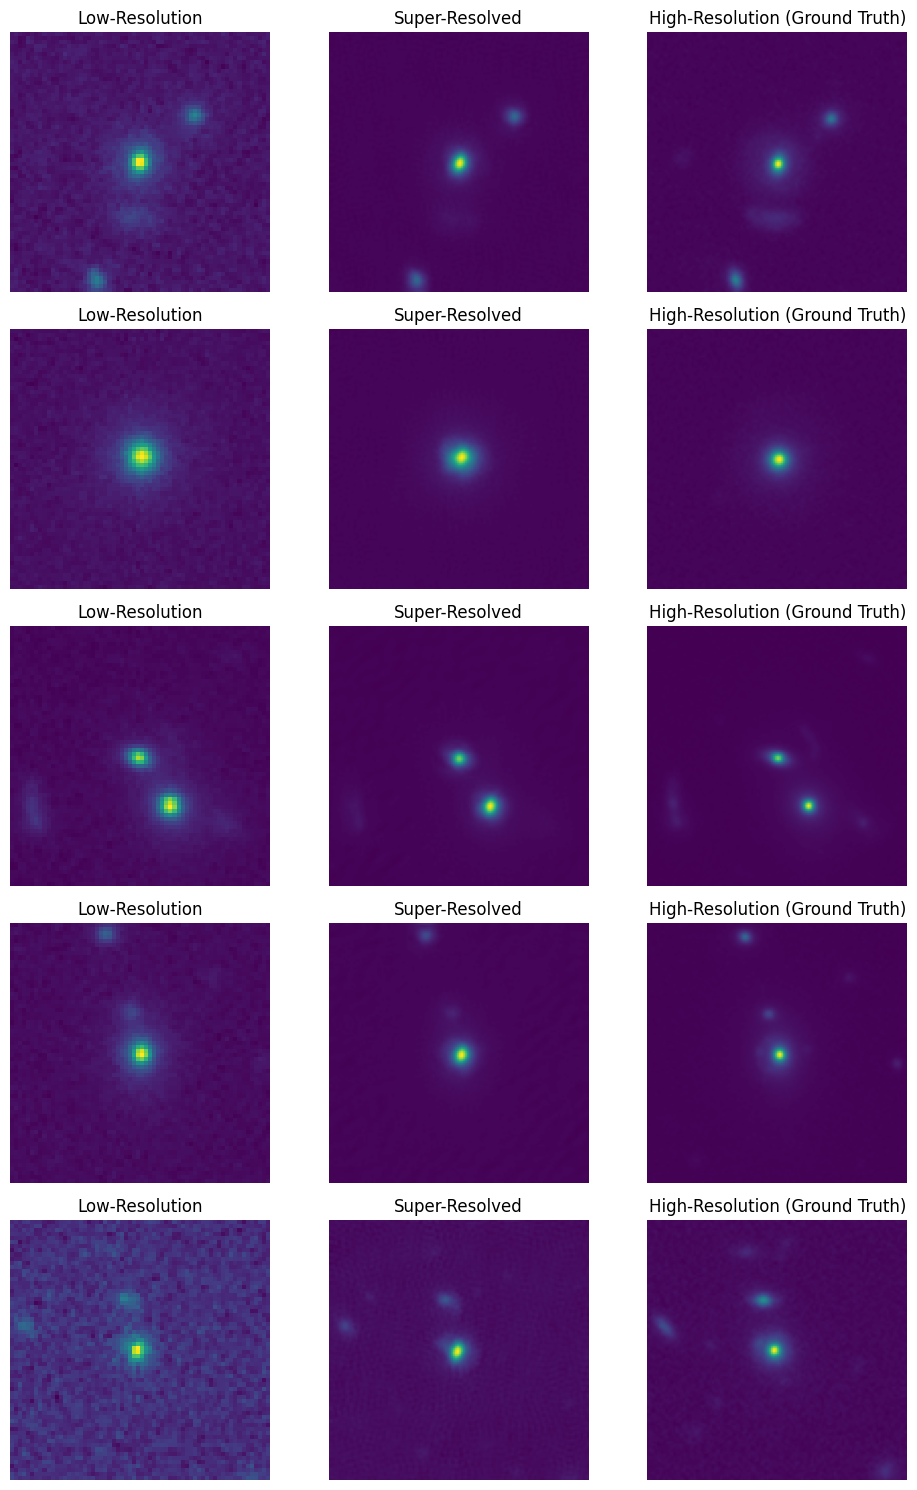

Final Evaluation - MSE: 0.0007645150971560118, PSNR: 35.21323692730531, SSIM: 0.8576015591621399


In [35]:
model = SRCNN(2, 32, [16], 9, [3], 5)
model = model.to(device)
model_save_path = "saved_models/best_sr_model_ft_2.pth"
model.load_state_dict(torch.load(model_save_path))
visualize_results(model, test_loader, num_samples=5, device=device)

model.eval()

# Evaluation loop
total_psnr, total_ssim, total_mse = 0.0, 0.0, 0.0
num_images = 0

with torch.no_grad():
    for lr_imgs, hr_imgs in test_loader:
        lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
        sr_imgs = model(lr_imgs)  # Generate SR images

        # Compute MSE, PSNR & SSIM for each image
        for i in range(lr_imgs.shape[0]):
            total_mse += mse(sr_imgs[i], hr_imgs[i])
            total_psnr += psnr(sr_imgs[i], hr_imgs[i], 255)
            total_ssim += ssim(sr_imgs[i].unsqueeze(0), hr_imgs[i].unsqueeze(0))
            num_images += 1

# Compute final average MSE, PSNR & SSIM
avg_mse = total_mse / num_images
avg_psnr = total_psnr / num_images
avg_ssim = total_ssim / num_images

print(f"Final Evaluation - MSE: {avg_mse}, PSNR: {avg_psnr}, SSIM: {avg_ssim}")

## ESPRCNN

In [36]:
model = ESPCN(kernel_sizes=[9, 7, 5, 3], inp_channels=[1, 64, 32, 16], out_channels=[64, 32, 16, 16], scale_factor=2)
model = model.to(device)
model_load_path = "saved_models/espcn_model_1.pth" 
model.load_state_dict(torch.load(model_load_path))

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 200
patience = 10  # Stop training if no improvement for 5 consecutive epochs
best_val_loss = float('inf')
epochs_no_improve = 0
model_save_path = "saved_models/best_espcn_model_ft_1.pth"  # Path to save the best model

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for lr_imgs, hr_imgs in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)

        sr_imgs = model(lr_imgs)

        loss = criterion(sr_imgs, hr_imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # Validation step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for lr_imgs, hr_imgs in test_loader:
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
            sr_imgs = model(lr_imgs)
            val_loss += criterion(sr_imgs, hr_imgs).item()

    avg_val_loss = val_loss / len(test_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")

    # Early Stopping & Model Saving
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), model_save_path)  # Save best model
        print(f"✔ Model saved with Val Loss: {best_val_loss}")
    else:
        epochs_no_improve += 1
        print(f"❌ No improvement for {epochs_no_improve}/{patience} epochs.")

    if epochs_no_improve >= patience:
        print("⏹ Early stopping triggered!")
        break  # Stop training if no improvement for 'patience' epochs

print("✅ Training complete!")
print(f"📁 Best model saved at: {model_save_path}")

Epoch 1/200:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 1/200: 100%|██████████| 17/17 [00:00<00:00, 25.62it/s]


Epoch [1/200] - Train Loss: 0.0025918054640950527, Val Loss: 0.0011984056036453694
✔ Model saved with Val Loss: 0.0011984056036453694


Epoch 2/200: 100%|██████████| 17/17 [00:00<00:00, 28.07it/s]


Epoch [2/200] - Train Loss: 0.0016617686282295514, Val Loss: 0.0010930516000371426
✔ Model saved with Val Loss: 0.0010930516000371426


Epoch 3/200: 100%|██████████| 17/17 [00:00<00:00, 29.52it/s]


Epoch [3/200] - Train Loss: 0.0015219675192116376, Val Loss: 0.0009932896064128727
✔ Model saved with Val Loss: 0.0009932896064128727


Epoch 4/200: 100%|██████████| 17/17 [00:00<00:00, 29.56it/s]


Epoch [4/200] - Train Loss: 0.0014831363737090107, Val Loss: 0.00096006783132907
✔ Model saved with Val Loss: 0.00096006783132907


Epoch 5/200: 100%|██████████| 17/17 [00:00<00:00, 29.13it/s]


Epoch [5/200] - Train Loss: 0.001446422326433308, Val Loss: 0.0009484578622505069
✔ Model saved with Val Loss: 0.0009484578622505069


Epoch 6/200: 100%|██████████| 17/17 [00:00<00:00, 28.49it/s]


Epoch [6/200] - Train Loss: 0.001407630875131444, Val Loss: 0.0009793591016205028
❌ No improvement for 1/10 epochs.


Epoch 7/200: 100%|██████████| 17/17 [00:00<00:00, 29.49it/s]


Epoch [7/200] - Train Loss: 0.0014095413156182451, Val Loss: 0.000930364549276419
✔ Model saved with Val Loss: 0.000930364549276419


Epoch 8/200: 100%|██████████| 17/17 [00:00<00:00, 29.42it/s]


Epoch [8/200] - Train Loss: 0.0013776431818876196, Val Loss: 0.0009250624279957265
✔ Model saved with Val Loss: 0.0009250624279957265


Epoch 9/200: 100%|██████████| 17/17 [00:00<00:00, 29.63it/s]


Epoch [9/200] - Train Loss: 0.0013851076741155017, Val Loss: 0.0009035242546815425
✔ Model saved with Val Loss: 0.0009035242546815425


Epoch 10/200: 100%|██████████| 17/17 [00:00<00:00, 29.63it/s]


Epoch [10/200] - Train Loss: 0.0013417404843494296, Val Loss: 0.0009196512546623126
❌ No improvement for 1/10 epochs.


Epoch 11/200: 100%|██████████| 17/17 [00:00<00:00, 29.70it/s]


Epoch [11/200] - Train Loss: 0.0014016396051053615, Val Loss: 0.0009270932932849973
❌ No improvement for 2/10 epochs.


Epoch 12/200: 100%|██████████| 17/17 [00:00<00:00, 29.50it/s]


Epoch [12/200] - Train Loss: 0.0014149782193057677, Val Loss: 0.0009005784522742033
✔ Model saved with Val Loss: 0.0009005784522742033


Epoch 13/200: 100%|██████████| 17/17 [00:00<00:00, 28.78it/s]


Epoch [13/200] - Train Loss: 0.0013474031789776158, Val Loss: 0.0009595020965207368
❌ No improvement for 1/10 epochs.


Epoch 14/200: 100%|██████████| 17/17 [00:00<00:00, 28.76it/s]


Epoch [14/200] - Train Loss: 0.0013111926159848843, Val Loss: 0.0008801537624094635
✔ Model saved with Val Loss: 0.0008801537624094635


Epoch 15/200: 100%|██████████| 17/17 [00:00<00:00, 28.95it/s]


Epoch [15/200] - Train Loss: 0.0012967287124518085, Val Loss: 0.0008887793228495866
❌ No improvement for 1/10 epochs.


Epoch 16/200: 100%|██████████| 17/17 [00:00<00:00, 28.95it/s]


Epoch [16/200] - Train Loss: 0.0012913472173215054, Val Loss: 0.0009154026338364929
❌ No improvement for 2/10 epochs.


Epoch 17/200: 100%|██████████| 17/17 [00:00<00:00, 28.79it/s]


Epoch [17/200] - Train Loss: 0.0012871560038012616, Val Loss: 0.0008560614223824814
✔ Model saved with Val Loss: 0.0008560614223824814


Epoch 18/200: 100%|██████████| 17/17 [00:00<00:00, 29.52it/s]


Epoch [18/200] - Train Loss: 0.001268737074604039, Val Loss: 0.0008872920734575018
❌ No improvement for 1/10 epochs.


Epoch 19/200: 100%|██████████| 17/17 [00:00<00:00, 29.52it/s]


Epoch [19/200] - Train Loss: 0.0012615333030493382, Val Loss: 0.0008548151090508327
✔ Model saved with Val Loss: 0.0008548151090508327


Epoch 20/200: 100%|██████████| 17/17 [00:00<00:00, 29.39it/s]


Epoch [20/200] - Train Loss: 0.0012706927886671003, Val Loss: 0.0008794322347966954
❌ No improvement for 1/10 epochs.


Epoch 21/200: 100%|██████████| 17/17 [00:00<00:00, 29.40it/s]


Epoch [21/200] - Train Loss: 0.00131280640455182, Val Loss: 0.0009261695086024702
❌ No improvement for 2/10 epochs.


Epoch 22/200: 100%|██████████| 17/17 [00:00<00:00, 28.55it/s]


Epoch [22/200] - Train Loss: 0.0012500812693307286, Val Loss: 0.0008673247357364744
❌ No improvement for 3/10 epochs.


Epoch 23/200: 100%|██████████| 17/17 [00:00<00:00, 29.51it/s]


Epoch [23/200] - Train Loss: 0.001234216838116374, Val Loss: 0.000872436969075352
❌ No improvement for 4/10 epochs.


Epoch 24/200: 100%|██████████| 17/17 [00:00<00:00, 29.56it/s]


Epoch [24/200] - Train Loss: 0.0012342575903269736, Val Loss: 0.0008487450832035393
✔ Model saved with Val Loss: 0.0008487450832035393


Epoch 25/200: 100%|██████████| 17/17 [00:00<00:00, 28.57it/s]


Epoch [25/200] - Train Loss: 0.001230586217442418, Val Loss: 0.0008477688097627833
✔ Model saved with Val Loss: 0.0008477688097627833


Epoch 26/200: 100%|██████████| 17/17 [00:00<00:00, 28.44it/s]


Epoch [26/200] - Train Loss: 0.001209788296631921, Val Loss: 0.0008518458198523149
❌ No improvement for 1/10 epochs.


Epoch 27/200: 100%|██████████| 17/17 [00:00<00:00, 28.95it/s]


Epoch [27/200] - Train Loss: 0.0011936965097180184, Val Loss: 0.0009479674481553957
❌ No improvement for 2/10 epochs.


Epoch 28/200: 100%|██████████| 17/17 [00:00<00:00, 28.84it/s]


Epoch [28/200] - Train Loss: 0.0012217647642554605, Val Loss: 0.0008537324902135879
❌ No improvement for 3/10 epochs.


Epoch 29/200: 100%|██████████| 17/17 [00:00<00:00, 27.84it/s]


Epoch [29/200] - Train Loss: 0.001208123388042783, Val Loss: 0.0008653022523503751
❌ No improvement for 4/10 epochs.


Epoch 30/200: 100%|██████████| 17/17 [00:00<00:00, 28.75it/s]


Epoch [30/200] - Train Loss: 0.0012507433352498885, Val Loss: 0.0008673179108882323
❌ No improvement for 5/10 epochs.


Epoch 31/200: 100%|██████████| 17/17 [00:00<00:00, 28.61it/s]


Epoch [31/200] - Train Loss: 0.0011917694868958171, Val Loss: 0.0009020747093018144
❌ No improvement for 6/10 epochs.


Epoch 32/200: 100%|██████████| 17/17 [00:00<00:00, 29.00it/s]


Epoch [32/200] - Train Loss: 0.0012087310109670985, Val Loss: 0.0008472632907796651
✔ Model saved with Val Loss: 0.0008472632907796651


Epoch 33/200: 100%|██████████| 17/17 [00:00<00:00, 28.98it/s]


Epoch [33/200] - Train Loss: 0.0011807823817327838, Val Loss: 0.0008930329349823296
❌ No improvement for 1/10 epochs.


Epoch 34/200: 100%|██████████| 17/17 [00:00<00:00, 29.14it/s]


Epoch [34/200] - Train Loss: 0.0012057676349821337, Val Loss: 0.0008651525859022513
❌ No improvement for 2/10 epochs.


Epoch 35/200: 100%|██████████| 17/17 [00:00<00:00, 29.63it/s]


Epoch [35/200] - Train Loss: 0.0011891819235375699, Val Loss: 0.0008647791255498305
❌ No improvement for 3/10 epochs.


Epoch 36/200: 100%|██████████| 17/17 [00:00<00:00, 28.96it/s]


Epoch [36/200] - Train Loss: 0.0011796348724815557, Val Loss: 0.0008910100150387734
❌ No improvement for 4/10 epochs.


Epoch 37/200: 100%|██████████| 17/17 [00:00<00:00, 29.41it/s]


Epoch [37/200] - Train Loss: 0.0012023384059669778, Val Loss: 0.0008655905548948795
❌ No improvement for 5/10 epochs.


Epoch 38/200: 100%|██████████| 17/17 [00:00<00:00, 28.45it/s]


Epoch [38/200] - Train Loss: 0.001167027628980577, Val Loss: 0.0008424298139289021
✔ Model saved with Val Loss: 0.0008424298139289021


Epoch 39/200: 100%|██████████| 17/17 [00:00<00:00, 29.42it/s]


Epoch [39/200] - Train Loss: 0.0011737481211586034, Val Loss: 0.0008769459964241832
❌ No improvement for 1/10 epochs.


Epoch 40/200: 100%|██████████| 17/17 [00:00<00:00, 29.32it/s]


Epoch [40/200] - Train Loss: 0.001180128045448595, Val Loss: 0.0008371457224711776
✔ Model saved with Val Loss: 0.0008371457224711776


Epoch 41/200: 100%|██████████| 17/17 [00:00<00:00, 29.37it/s]


Epoch [41/200] - Train Loss: 0.0011842232762479827, Val Loss: 0.0009051305241882801
❌ No improvement for 1/10 epochs.


Epoch 42/200: 100%|██████████| 17/17 [00:00<00:00, 29.57it/s]


Epoch [42/200] - Train Loss: 0.001207355728290756, Val Loss: 0.0008345248934347183
✔ Model saved with Val Loss: 0.0008345248934347183


Epoch 43/200: 100%|██████████| 17/17 [00:00<00:00, 29.23it/s]


Epoch [43/200] - Train Loss: 0.0011612653050927773, Val Loss: 0.0008656435384182259
❌ No improvement for 1/10 epochs.


Epoch 44/200: 100%|██████████| 17/17 [00:00<00:00, 29.37it/s]


Epoch [44/200] - Train Loss: 0.001179217590320417, Val Loss: 0.0008447086729574949
❌ No improvement for 2/10 epochs.


Epoch 45/200: 100%|██████████| 17/17 [00:00<00:00, 28.27it/s]


Epoch [45/200] - Train Loss: 0.0011896597331061082, Val Loss: 0.000831432465929538
✔ Model saved with Val Loss: 0.000831432465929538


Epoch 46/200: 100%|██████████| 17/17 [00:00<00:00, 28.68it/s]


Epoch [46/200] - Train Loss: 0.0011526351736392826, Val Loss: 0.0008479135867673904
❌ No improvement for 1/10 epochs.


Epoch 47/200: 100%|██████████| 17/17 [00:00<00:00, 28.38it/s]


Epoch [47/200] - Train Loss: 0.0011994620384511484, Val Loss: 0.0008760463097132742
❌ No improvement for 2/10 epochs.


Epoch 48/200: 100%|██████████| 17/17 [00:00<00:00, 28.50it/s]


Epoch [48/200] - Train Loss: 0.0012271074554198148, Val Loss: 0.0008746138628339395
❌ No improvement for 3/10 epochs.


Epoch 49/200: 100%|██████████| 17/17 [00:00<00:00, 29.60it/s]


Epoch [49/200] - Train Loss: 0.001163987530162558, Val Loss: 0.000830138596938923
✔ Model saved with Val Loss: 0.000830138596938923


Epoch 50/200: 100%|██████████| 17/17 [00:00<00:00, 29.59it/s]


Epoch [50/200] - Train Loss: 0.001153294265831766, Val Loss: 0.0008552920626243576
❌ No improvement for 1/10 epochs.


Epoch 51/200: 100%|██████████| 17/17 [00:00<00:00, 29.51it/s]


Epoch [51/200] - Train Loss: 0.001147797577740515, Val Loss: 0.0008749025291763246
❌ No improvement for 2/10 epochs.


Epoch 52/200: 100%|██████████| 17/17 [00:00<00:00, 29.34it/s]


Epoch [52/200] - Train Loss: 0.0011584019504131422, Val Loss: 0.0008229294617194682
✔ Model saved with Val Loss: 0.0008229294617194682


Epoch 53/200: 100%|██████████| 17/17 [00:00<00:00, 29.30it/s]


Epoch [53/200] - Train Loss: 0.0011541880170732517, Val Loss: 0.0008209600055124611
✔ Model saved with Val Loss: 0.0008209600055124611


Epoch 54/200: 100%|██████████| 17/17 [00:00<00:00, 27.96it/s]


Epoch [54/200] - Train Loss: 0.0011391609218930278, Val Loss: 0.000822252404759638
❌ No improvement for 1/10 epochs.


Epoch 55/200: 100%|██████████| 17/17 [00:00<00:00, 29.19it/s]


Epoch [55/200] - Train Loss: 0.0011840231668697123, Val Loss: 0.0008364753448404372
❌ No improvement for 2/10 epochs.


Epoch 56/200: 100%|██████████| 17/17 [00:00<00:00, 28.35it/s]


Epoch [56/200] - Train Loss: 0.0011858286692158265, Val Loss: 0.0008451309113297611
❌ No improvement for 3/10 epochs.


Epoch 57/200: 100%|██████████| 17/17 [00:00<00:00, 29.06it/s]


Epoch [57/200] - Train Loss: 0.001146060154389809, Val Loss: 0.0008308723627123982
❌ No improvement for 4/10 epochs.


Epoch 58/200: 100%|██████████| 17/17 [00:00<00:00, 29.34it/s]


Epoch [58/200] - Train Loss: 0.0011282531400758993, Val Loss: 0.0008154325769282877
✔ Model saved with Val Loss: 0.0008154325769282877


Epoch 59/200: 100%|██████████| 17/17 [00:00<00:00, 29.37it/s]


Epoch [59/200] - Train Loss: 0.0011550995541791268, Val Loss: 0.0008443949336651713
❌ No improvement for 1/10 epochs.


Epoch 60/200: 100%|██████████| 17/17 [00:00<00:00, 29.57it/s]


Epoch [60/200] - Train Loss: 0.0011407124881824369, Val Loss: 0.0008322313369717449
❌ No improvement for 2/10 epochs.


Epoch 61/200: 100%|██████████| 17/17 [00:00<00:00, 29.58it/s]


Epoch [61/200] - Train Loss: 0.0011507913792122375, Val Loss: 0.0008411778981098905
❌ No improvement for 3/10 epochs.


Epoch 62/200: 100%|██████████| 17/17 [00:00<00:00, 27.50it/s]


Epoch [62/200] - Train Loss: 0.0011370258905705722, Val Loss: 0.0008737370953895152
❌ No improvement for 4/10 epochs.


Epoch 63/200: 100%|██████████| 17/17 [00:00<00:00, 29.50it/s]


Epoch [63/200] - Train Loss: 0.0012380363837377552, Val Loss: 0.0008300322951981798
❌ No improvement for 5/10 epochs.


Epoch 64/200: 100%|██████████| 17/17 [00:00<00:00, 29.57it/s]


Epoch [64/200] - Train Loss: 0.0011542344085789997, Val Loss: 0.0008262604678748176
❌ No improvement for 6/10 epochs.


Epoch 65/200: 100%|██████████| 17/17 [00:00<00:00, 29.42it/s]


Epoch [65/200] - Train Loss: 0.0011561280150678666, Val Loss: 0.0008231880783569068
❌ No improvement for 7/10 epochs.


Epoch 66/200: 100%|██████████| 17/17 [00:00<00:00, 29.47it/s]


Epoch [66/200] - Train Loss: 0.0011538654250804992, Val Loss: 0.0008542545838281512
❌ No improvement for 8/10 epochs.


Epoch 67/200: 100%|██████████| 17/17 [00:00<00:00, 29.44it/s]


Epoch [67/200] - Train Loss: 0.0011737449385691434, Val Loss: 0.0008479123353026807
❌ No improvement for 9/10 epochs.


Epoch 68/200: 100%|██████████| 17/17 [00:00<00:00, 29.38it/s]

Epoch [68/200] - Train Loss: 0.0011834284078384586, Val Loss: 0.0008256860310211778
❌ No improvement for 10/10 epochs.
⏹ Early stopping triggered!
✅ Training complete!
📁 Best model saved at: saved_models/best_espcn_model_ft_1.pth


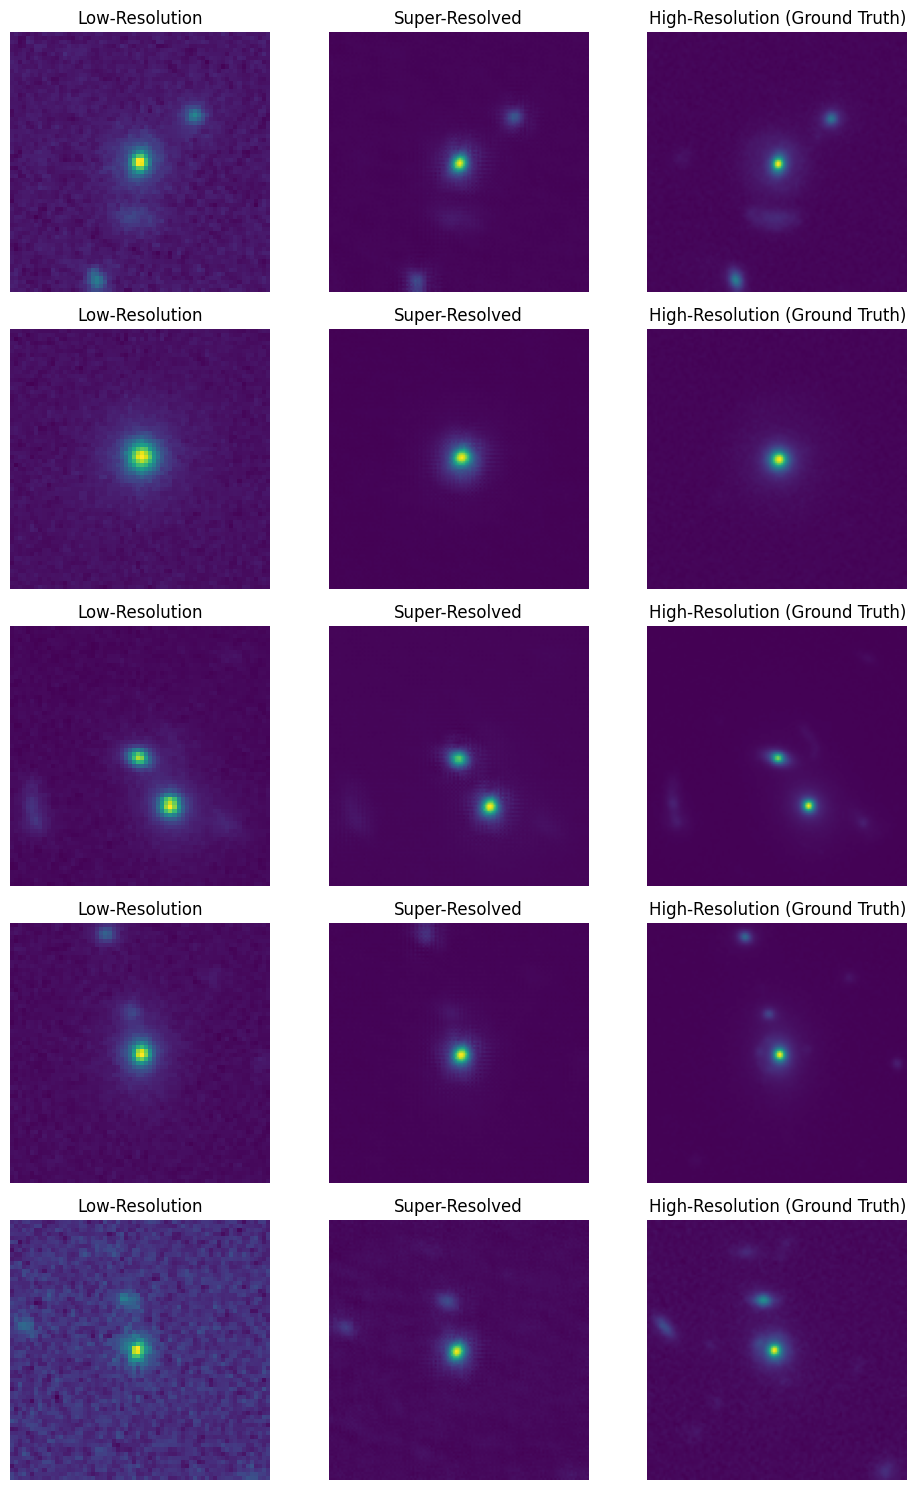

Final Evaluation - MSE: 0.0007788492572823694, PSNR: 35.39417348870955, SSIM: 0.8734989364941915


In [37]:
model = ESPCN(kernel_sizes=[9, 7, 5, 3], inp_channels=[1, 64, 32, 16], out_channels=[64, 32, 16, 16], scale_factor=2)
model = model.to(device)
model_save_path = "saved_models/best_espcn_model_ft_1.pth"
model.load_state_dict(torch.load(model_save_path))
visualize_results(model, test_loader, num_samples=5, device=device)

model.eval()

# Evaluation loop
total_psnr, total_ssim, total_mse = 0.0, 0.0, 0.0
num_images = 0

with torch.no_grad():
    for lr_imgs, hr_imgs in test_loader:
        lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
        sr_imgs = model(lr_imgs)  # Generate SR images

        # Compute MSE, PSNR & SSIM for each image
        for i in range(lr_imgs.shape[0]):
            total_mse += mse(sr_imgs[i], hr_imgs[i])
            total_psnr += psnr(sr_imgs[i], hr_imgs[i], 255)
            total_ssim += ssim(sr_imgs[i].unsqueeze(0), hr_imgs[i].unsqueeze(0))
            num_images += 1

# Compute final average MSE, PSNR & SSIM
avg_mse = total_mse / num_images
avg_psnr = total_psnr / num_images
avg_ssim = total_ssim / num_images

print(f"Final Evaluation - MSE: {avg_mse}, PSNR: {avg_psnr}, SSIM: {avg_ssim}")

## SRResNet

In [38]:
model = SRGenerator(1, 64, (3, 3), (9, 9), 4, upscale_factor=2).to(device)
model = model.to(device)
model_load_path = "saved_models/srresnet_model_1.pth"
model.load_state_dict(torch.load(model_load_path))

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 200
patience = 10  # Stop training if no improvement for 5 consecutive epochs
best_val_loss = float('inf')
epochs_no_improve = 0
model_save_path = "saved_models/best_srresnet_model_ft_1.pth"  # Path to save the best model

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for lr_imgs, hr_imgs in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)

        sr_imgs = model(lr_imgs)

        loss = criterion(sr_imgs, hr_imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # Validation step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for lr_imgs, hr_imgs in test_loader:
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
            sr_imgs = model(lr_imgs)
            val_loss += criterion(sr_imgs, hr_imgs).item()

    avg_val_loss = val_loss / len(test_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")

    # Early Stopping & Model Saving
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), model_save_path)  # Save best model
        print(f"✔ Model saved with Val Loss: {best_val_loss}")
    else:
        epochs_no_improve += 1
        print(f"❌ No improvement for {epochs_no_improve}/{patience} epochs.")

    if epochs_no_improve >= patience:
        print("⏹ Early stopping triggered!")
        break  # Stop training if no improvement for 'patience' epochs

print("✅ Training complete!")
print(f"📁 Best model saved at: {model_save_path}")

Epoch 1/200: 100%|██████████| 17/17 [00:06<00:00,  2.53it/s]


Epoch [1/200] - Train Loss: 0.00212242134833051, Val Loss: 0.0013583457912318408
✔ Model saved with Val Loss: 0.0013583457912318408


Epoch 2/200: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [2/200] - Train Loss: 0.00147658574175747, Val Loss: 0.0015115591522771865
❌ No improvement for 1/10 epochs.


Epoch 3/200: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [3/200] - Train Loss: 0.001346151200670968, Val Loss: 0.0009757479128893465
✔ Model saved with Val Loss: 0.0009757479128893465


Epoch 4/200: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [4/200] - Train Loss: 0.001316683757228448, Val Loss: 0.0010296394175384194
❌ No improvement for 1/10 epochs.


Epoch 5/200: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [5/200] - Train Loss: 0.0013072945807567414, Val Loss: 0.0009751752950251102
✔ Model saved with Val Loss: 0.0009751752950251102


Epoch 6/200: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [6/200] - Train Loss: 0.0012681312475572614, Val Loss: 0.0010177403164561838
❌ No improvement for 1/10 epochs.


Epoch 7/200: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [7/200] - Train Loss: 0.0012678083867820747, Val Loss: 0.000936540134716779
✔ Model saved with Val Loss: 0.000936540134716779


Epoch 8/200: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [8/200] - Train Loss: 0.0012842543792965658, Val Loss: 0.0012891115620732307
❌ No improvement for 1/10 epochs.


Epoch 9/200: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [9/200] - Train Loss: 0.00130189344396486, Val Loss: 0.0009683269163360819
❌ No improvement for 2/10 epochs.


Epoch 10/200: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [10/200] - Train Loss: 0.0012940088944400057, Val Loss: 0.0008797371410764754
✔ Model saved with Val Loss: 0.0008797371410764754


Epoch 11/200: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [11/200] - Train Loss: 0.0011912036485120874, Val Loss: 0.001000756281428039
❌ No improvement for 1/10 epochs.


Epoch 12/200: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [12/200] - Train Loss: 0.0012250854257110726, Val Loss: 0.0009554707939969376
❌ No improvement for 2/10 epochs.


Epoch 13/200: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [13/200] - Train Loss: 0.0012136646340984631, Val Loss: 0.0010122369567397982
❌ No improvement for 3/10 epochs.


Epoch 14/200: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [14/200] - Train Loss: 0.0012395493001403177, Val Loss: 0.0009513920522294939
❌ No improvement for 4/10 epochs.


Epoch 15/200: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [15/200] - Train Loss: 0.001272661508718396, Val Loss: 0.0014672388788312674
❌ No improvement for 5/10 epochs.


Epoch 16/200: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [16/200] - Train Loss: 0.0012315136880394729, Val Loss: 0.0008774469897616655
✔ Model saved with Val Loss: 0.0008774469897616655


Epoch 17/200: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [17/200] - Train Loss: 0.0012015127542647807, Val Loss: 0.003096845932304859
❌ No improvement for 1/10 epochs.


Epoch 18/200: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [18/200] - Train Loss: 0.0012225838624598348, Val Loss: 0.0010041531786555424
❌ No improvement for 2/10 epochs.


Epoch 19/200: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [19/200] - Train Loss: 0.0011809053454164635, Val Loss: 0.0016234212089329958
❌ No improvement for 3/10 epochs.


Epoch 20/200: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [20/200] - Train Loss: 0.001260123568285695, Val Loss: 0.001018345181364566
❌ No improvement for 4/10 epochs.


Epoch 21/200: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [21/200] - Train Loss: 0.001283464304459117, Val Loss: 0.0010454557777848095
❌ No improvement for 5/10 epochs.


Epoch 22/200: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [22/200] - Train Loss: 0.0011745720351909233, Val Loss: 0.0008660700113978237
✔ Model saved with Val Loss: 0.0008660700113978237


Epoch 23/200: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [23/200] - Train Loss: 0.0012258771457709372, Val Loss: 0.0023520970717072487
❌ No improvement for 1/10 epochs.


Epoch 24/200: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [24/200] - Train Loss: 0.0011826643997611588, Val Loss: 0.0009314289054600522
❌ No improvement for 2/10 epochs.


Epoch 25/200: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [25/200] - Train Loss: 0.0012714334862881944, Val Loss: 0.0009172262216452509
❌ No improvement for 3/10 epochs.


Epoch 26/200: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [26/200] - Train Loss: 0.001201847059693297, Val Loss: 0.0009153698338195682
❌ No improvement for 4/10 epochs.


Epoch 27/200: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [27/200] - Train Loss: 0.001196641894399791, Val Loss: 0.0009836856770562008
❌ No improvement for 5/10 epochs.


Epoch 28/200: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [28/200] - Train Loss: 0.0011960247408269958, Val Loss: 0.0010691143106669188
❌ No improvement for 6/10 epochs.


Epoch 29/200: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [29/200] - Train Loss: 0.0011778402909198228, Val Loss: 0.0009621296194382012
❌ No improvement for 7/10 epochs.


Epoch 30/200: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [30/200] - Train Loss: 0.0011269536540460061, Val Loss: 0.0011251925607211888
❌ No improvement for 8/10 epochs.


Epoch 31/200: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [31/200] - Train Loss: 0.0011664628331987735, Val Loss: 0.0008291410922538489
✔ Model saved with Val Loss: 0.0008291410922538489


Epoch 32/200: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [32/200] - Train Loss: 0.0011288518897559056, Val Loss: 0.0008182760066119954
✔ Model saved with Val Loss: 0.0008182760066119954


Epoch 33/200: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [33/200] - Train Loss: 0.0011544497854843298, Val Loss: 0.000993651497992687
❌ No improvement for 1/10 epochs.


Epoch 34/200: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [34/200] - Train Loss: 0.0011361006061847815, Val Loss: 0.0012853770749643445
❌ No improvement for 2/10 epochs.


Epoch 35/200: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [35/200] - Train Loss: 0.00117179419098915, Val Loss: 0.001211359747685492
❌ No improvement for 3/10 epochs.


Epoch 36/200: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [36/200] - Train Loss: 0.0011617866865194896, Val Loss: 0.001044327043928206
❌ No improvement for 4/10 epochs.


Epoch 37/200: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [37/200] - Train Loss: 0.0011792043052778086, Val Loss: 0.0009756579675013199
❌ No improvement for 5/10 epochs.


Epoch 38/200: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [38/200] - Train Loss: 0.0011571944478954025, Val Loss: 0.001071792677976191
❌ No improvement for 6/10 epochs.


Epoch 39/200: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [39/200] - Train Loss: 0.0011895895962986875, Val Loss: 0.0008273636922240257
❌ No improvement for 7/10 epochs.


Epoch 40/200: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [40/200] - Train Loss: 0.0011455127250348382, Val Loss: 0.0011674371489789337
❌ No improvement for 8/10 epochs.


Epoch 41/200: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [41/200] - Train Loss: 0.0011350758825702703, Val Loss: 0.000829601995064877
❌ No improvement for 9/10 epochs.


Epoch 42/200: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]

Epoch [42/200] - Train Loss: 0.0011389025209663326, Val Loss: 0.001681895984802395
❌ No improvement for 10/10 epochs.
⏹ Early stopping triggered!
✅ Training complete!
📁 Best model saved at: saved_models/best_srresnet_model_ft_1.pth


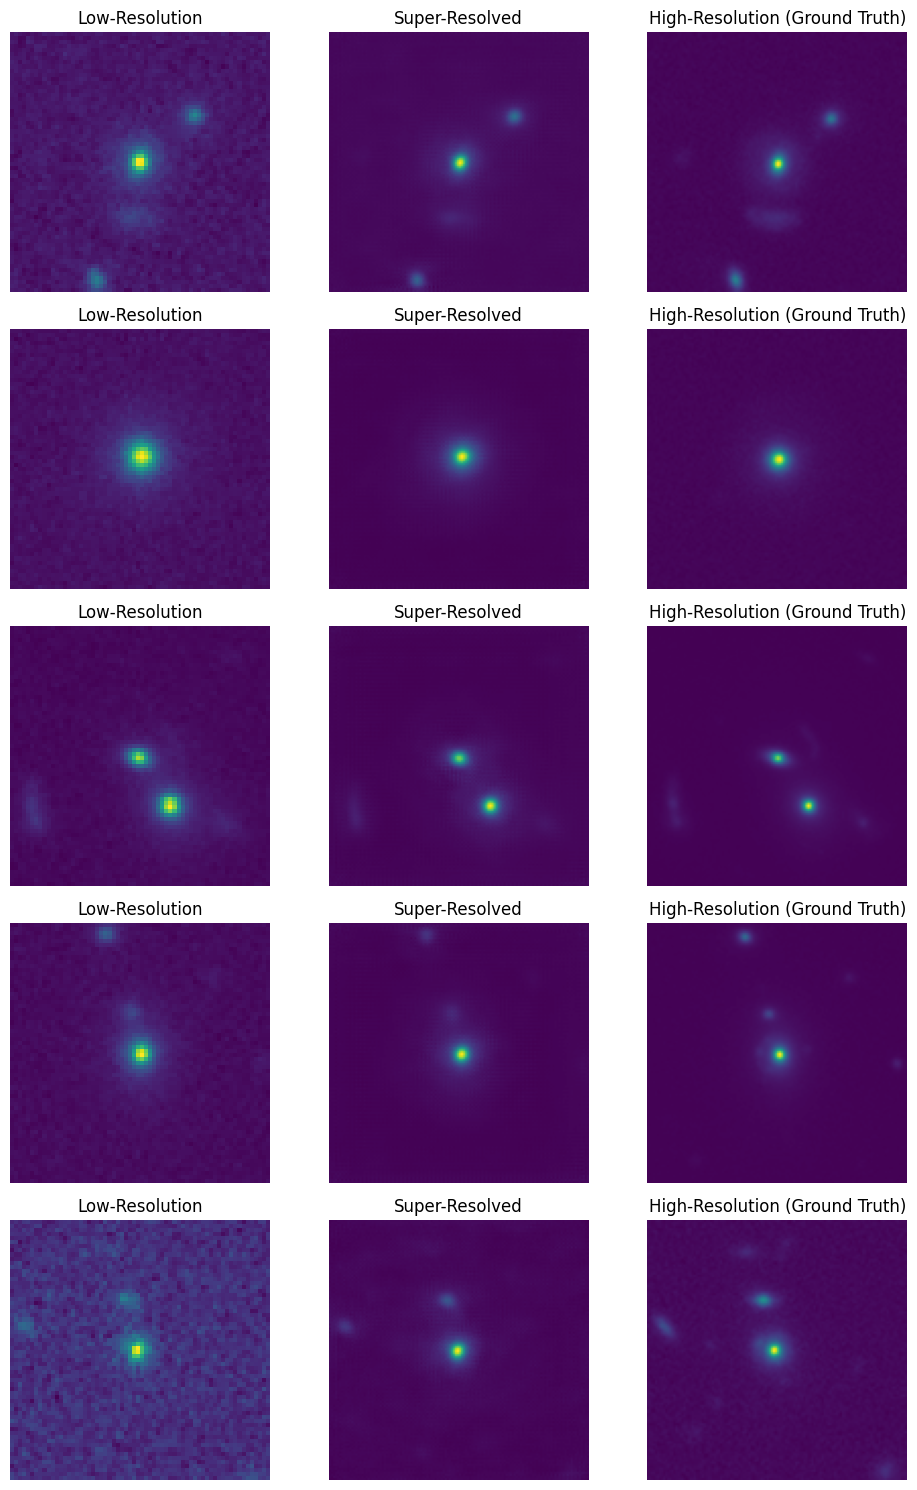

Final Evaluation - MSE: 0.0007827904955775011, PSNR: 35.24461601752956, SSIM: 0.8417196949323018


In [39]:
model = SRGenerator(1, 64, (3, 3), (9, 9), 4, upscale_factor=2).to(device)
model = model.to(device)
model_save_path = "saved_models/best_srresnet_model_ft_1.pth"
model.load_state_dict(torch.load(model_save_path))
visualize_results(model, test_loader, num_samples=5, device=device)

model.eval()

# Evaluation loop
total_psnr, total_ssim, total_mse = 0.0, 0.0, 0.0
num_images = 0

with torch.no_grad():
    for lr_imgs, hr_imgs in test_loader:
        lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
        sr_imgs = model(lr_imgs)  # Generate SR images

        # Compute MSE, PSNR & SSIM for each image
        for i in range(lr_imgs.shape[0]):
            total_mse += mse(sr_imgs[i], hr_imgs[i])
            total_psnr += psnr(sr_imgs[i], hr_imgs[i], 255)
            total_ssim += ssim(sr_imgs[i].unsqueeze(0), hr_imgs[i].unsqueeze(0))
            num_images += 1

# Compute final average MSE, PSNR & SSIM
avg_mse = total_mse / num_images
avg_psnr = total_psnr / num_images
avg_ssim = total_ssim / num_images

print(f"Final Evaluation - MSE: {avg_mse}, PSNR: {avg_psnr}, SSIM: {avg_ssim}")

# Final Results

| Model         | PSNR (dB)         | SSIM               | MSE                   |
|---------------|-------------------|--------------------|-----------------------|
| SRCNN-small   | 34.09434717290395 | 0.8582045892874400 | 0.0008473546695313416 |
| SRCNN-large   | 35.21323692730531 | 0.8576015591621399 | **0.0007645150971560118** |
| ESPCN         | **35.39417348870955** | **0.8734989364941915** | 0.0007788492572823694 |
| SRResNet      | 35.24461601752956 | 0.8417196949323018 | 0.0007827904955775011 |